In [53]:
%matplotlib inline
import os
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from decimal import ROUND_HALF_UP, Decimal
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler
import pickle
import joblib

In [2]:
import warnings
warnings.filterwarnings('ignore')

# Load & analyse the data

In [3]:
train_files_folder = '/home/olli/Projects/Kaggle/jpx/jpx_data/train_files'
supplemental_files_folder = '/home/olli/Projects/Kaggle/jpx/jpx_data/supplemental_files'

In [4]:
stock_prices_path = os.path.join(train_files_folder, 'stock_prices.csv')
stock_prices_path_add = os.path.join(supplemental_files_folder, 'stock_prices.csv')

In [5]:
stock_prices = pd.read_csv(stock_prices_path)
stock_prices_2 = pd.read_csv(stock_prices_path_add)

While the competition started new data from the stock markets was provided; all the data should be used

In [6]:
stock_prices.tail(3)

,RowId,Date,SecuritiesCode,Open,High,Low,Close,Volume,AdjustmentFactor,ExpectedDividend,SupervisionFlag,Target
2332528,20211203_9993,2021-12-03,9993,1690.0,1690.0,1645.0,1645.0,7200,1.0,NaN,False,-0.004302
2332529,20211203_9994,2021-12-03,9994,2388.0,2396.0,2380.0,2389.0,6500,1.0,NaN,False,0.009098
2332530,20211203_9997,2021-12-03,9997,690.0,711.0,686.0,696.0,381100,1.0,NaN,False,0.018414


In [7]:
stock_prices_2.head(3)

,RowId,Date,SecuritiesCode,Open,High,Low,Close,Volume,AdjustmentFactor,ExpectedDividend,SupervisionFlag,Target
0,20211206_1301,2021-12-06,1301,2982.0,2982.0,2965.0,2971.0,8900,1.0,NaN,False,-0.003263
1,20211206_1332,2021-12-06,1332,592.0,599.0,588.0,589.0,1360800,1.0,NaN,False,-0.008993
2,20211206_1333,2021-12-06,1333,2368.0,2388.0,2360.0,2377.0,125900,1.0,NaN,False,-0.009963


The dates show that the second df has the more recent dates (weekends are excluded as the stock exchange is closed)

### Spot missing data & decide how to handle it

In [8]:
stock_prices.info(show_counts=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2332531 entries, 0 to 2332530
Data columns (total 12 columns):
 #   Column            Non-Null Count    Dtype  
---  ------            --------------    -----  
 0   RowId             2332531 non-null  object 
 1   Date              2332531 non-null  object 
 2   SecuritiesCode    2332531 non-null  int64  
 3   Open              2324923 non-null  float64
 4   High              2324923 non-null  float64
 5   Low               2324923 non-null  float64
 6   Close             2324923 non-null  float64
 7   Volume            2332531 non-null  int64  
 8   AdjustmentFactor  2332531 non-null  float64
 9   ExpectedDividend  18865 non-null    float64
 10  SupervisionFlag   2332531 non-null  bool   
 11  Target            2332293 non-null  float64
dtypes: bool(1), float64(7), int64(2), object(2)
memory usage: 198.0+ MB


In [9]:
stock_prices_2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 195993 entries, 0 to 195992
Data columns (total 12 columns):
 #   Column            Non-Null Count   Dtype  
---  ------            --------------   -----  
 0   RowId             195993 non-null  object 
 1   Date              195993 non-null  object 
 2   SecuritiesCode    195993 non-null  int64  
 3   Open              195402 non-null  float64
 4   High              195402 non-null  float64
 5   Low               195402 non-null  float64
 6   Close             195402 non-null  float64
 7   Volume            195993 non-null  int64  
 8   AdjustmentFactor  195993 non-null  float64
 9   ExpectedDividend  1956 non-null    float64
 10  SupervisionFlag   195993 non-null  bool   
 11  Target            195989 non-null  float64
dtypes: bool(1), float64(7), int64(2), object(2)
memory usage: 16.6+ MB


ExpectedDividend: Most values are missing -> drop as a feature

Open, High, Low, Close, Target: Few missing values -> Drop the rows

In [10]:
DF = pd.concat([stock_prices, stock_prices_2], axis=0)  # combine both dataframes

In [11]:
DF.head()

,RowId,Date,SecuritiesCode,Open,High,Low,Close,Volume,AdjustmentFactor,ExpectedDividend,SupervisionFlag,Target
0,20170104_1301,2017-01-04,1301,2734.0,2755.0,2730.0,2742.0,31400,1.0,NaN,False,0.000730
1,20170104_1332,2017-01-04,1332,568.0,576.0,563.0,571.0,2798500,1.0,NaN,False,0.012324
2,20170104_1333,2017-01-04,1333,3150.0,3210.0,3140.0,3210.0,270800,1.0,NaN,False,0.006154
3,20170104_1376,2017-01-04,1376,1510.0,1550.0,1510.0,1550.0,11300,1.0,NaN,False,0.011053
4,20170104_1377,2017-01-04,1377,3270.0,3350.0,3270.0,3330.0,150800,1.0,NaN,False,0.003026


In [12]:
len(DF) == len(stock_prices) + len(stock_prices_2)

True

### Plot of the available stocks

In [13]:
stocks = DF[['Date', 'SecuritiesCode']]

In [14]:
stocks['Date'] = pd.to_datetime(stocks['Date'])

In [15]:
stocks = stocks.groupby('Date')['SecuritiesCode'].count().reset_index()

Text(0.5, 1.0, 'Available Stocks')

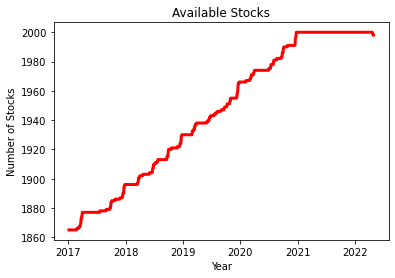

In [16]:
plt.plot(stocks['Date'], stocks['SecuritiesCode'], linewidth=3, color='red')
plt.xlabel('Year')
plt.ylabel('Number of Stocks')
plt.title('Available Stocks')

The number of stocks increased to 2000 stocks but decreased at the end - during the comp stocks might be delisted signaled by the feature 'SupervisionFlag'

### Plot of the target (stock returns)

Text(0.5, 1.0, 'Target Distribution')

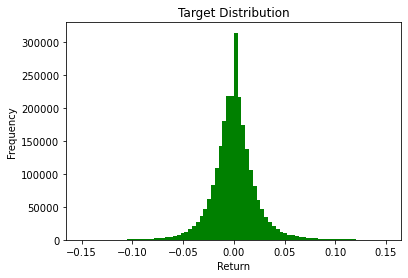

In [17]:
plt.hist(DF['Target'], bins=80, color='green', range=(-0.15, 0.15))
plt.xlabel('Return')
plt.ylabel('Frequency')
plt.title('Target Distribution')

# Preprocessing

1) Drop useless features and missing rows

2) Calculate Adjusted Close with the provided function (for stocks that split/merged)

In [18]:
def preprocess(data):
    df = data.copy()
    
    df.drop(['RowId', 'ExpectedDividend', 'SupervisionFlag'], axis=1, inplace=True)  # columns (featues) not needed
    
    df.dropna(axis=0, inplace=True) #  drop the rows with missing values
    
    df = df.sort_values(['Date', 'SecuritiesCode']).reset_index(drop=True)
    
    return df

In [19]:
df_prep = preprocess(DF)

In [20]:
df_prep.head()

,Date,SecuritiesCode,Open,High,Low,Close,Volume,AdjustmentFactor,Target
0,2017-01-04,1301,2734.0,2755.0,2730.0,2742.0,31400,1.0,0.000730
1,2017-01-04,1332,568.0,576.0,563.0,571.0,2798500,1.0,0.012324
2,2017-01-04,1333,3150.0,3210.0,3140.0,3210.0,270800,1.0,0.006154
3,2017-01-04,1376,1510.0,1550.0,1510.0,1550.0,11300,1.0,0.011053
4,2017-01-04,1377,3270.0,3350.0,3270.0,3330.0,150800,1.0,0.003026


The following function was provided by the host

In [21]:
def adjust_price(price):
    """
    Args:
        price (pd.DataFrame)  : pd.DataFrame include stock_price
    Returns:
        price DataFrame (pd.DataFrame): stock_price with generated AdjustedClose
    """
    # transform Date column into datetime
    price.loc[: ,"Date"] = pd.to_datetime(price.loc[: ,"Date"], format="%Y-%m-%d")

    def generate_adjusted_close(df):
        """
        Args:
            df (pd.DataFrame)  : stock_price for a single SecuritiesCode
        Returns:
            df (pd.DataFrame): stock_price with AdjustedClose for a single SecuritiesCode
        """
        # sort data to generate CumulativeAdjustmentFactor
        df = df.sort_values("Date", ascending=False)
        # generate CumulativeAdjustmentFactor
        df.loc[:, "CumulativeAdjustmentFactor"] = df["AdjustmentFactor"].cumprod()
        # generate AdjustedClose
        df.loc[:, "AdjustedClose"] = (
            df["CumulativeAdjustmentFactor"] * df["Close"]
        ).map(lambda x: float(
            Decimal(str(x)).quantize(Decimal('0.1'), rounding=ROUND_HALF_UP)
        ))
        # reverse order
        df = df.sort_values("Date")
        # to fill AdjustedClose, replace 0 into np.nan
        df.loc[df["AdjustedClose"] == 0, "AdjustedClose"] = np.nan
        # forward fill AdjustedClose
        df.loc[:, "AdjustedClose"] = df.loc[:, "AdjustedClose"].ffill()
        return df
    
    # generate AdjustedClose
    price = price.sort_values(["SecuritiesCode", "Date"])
    price = price.groupby("SecuritiesCode").apply(generate_adjusted_close).reset_index(drop=True)
    
    price.drop(['AdjustmentFactor', 'Close', 'CumulativeAdjustmentFactor'], axis=1, inplace=True)
    return price

In [22]:
df_adj = adjust_price(df_prep)

In [23]:
df_adj.head()

,Date,SecuritiesCode,Open,High,Low,Volume,Target,AdjustedClose
0,2017-01-04,1301,2734.0,2755.0,2730.0,31400,0.000730,2742.0
1,2017-01-05,1301,2743.0,2747.0,2735.0,17900,0.002920,2738.0
2,2017-01-06,1301,2734.0,2744.0,2720.0,19900,-0.001092,2740.0
3,2017-01-10,1301,2745.0,2754.0,2735.0,24200,-0.005100,2748.0
4,2017-01-11,1301,2748.0,2752.0,2737.0,9300,-0.003295,2745.0


In [24]:
df_adj = df_adj[['Date', 'SecuritiesCode', 'Open', 'High', 'Low', 'AdjustedClose', 'Volume', 'Target']]

In [25]:
df_adj.head()

,Date,SecuritiesCode,Open,High,Low,AdjustedClose,Volume,Target
0,2017-01-04,1301,2734.0,2755.0,2730.0,2742.0,31400,0.000730
1,2017-01-05,1301,2743.0,2747.0,2735.0,2738.0,17900,0.002920
2,2017-01-06,1301,2734.0,2744.0,2720.0,2740.0,19900,-0.001092
3,2017-01-10,1301,2745.0,2754.0,2735.0,2748.0,24200,-0.005100
4,2017-01-11,1301,2748.0,2752.0,2737.0,2745.0,9300,-0.003295


In [26]:
df_adj.info(show_counts=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2520321 entries, 0 to 2520320
Data columns (total 8 columns):
 #   Column          Non-Null Count    Dtype         
---  ------          --------------    -----         
 0   Date            2520321 non-null  datetime64[ns]
 1   SecuritiesCode  2520321 non-null  int64         
 2   Open            2520321 non-null  float64       
 3   High            2520321 non-null  float64       
 4   Low             2520321 non-null  float64       
 5   AdjustedClose   2520321 non-null  float64       
 6   Volume          2520321 non-null  int64         
 7   Target          2520321 non-null  float64       
dtypes: datetime64[ns](1), float64(5), int64(2)
memory usage: 153.8 MB


# Split the data without any data leakage

The target is calculated on the adjusted close of the next two days

Instead of using the TimeSeriesSplit from Sklearn a custom validation set way created

In [27]:
def train_test_split(DF):
    df = DF.copy()
    
    df['Date'] = df['Date'].dt.strftime('%Y-%m-%d')  # datetime to str
    
    days = len(df['Date'].unique()) #  number of days
    
    day_values = list(df['Date'].unique()) #  day values
    
    test_1_min = 0 #  splitting based on date values (80/20)
    test_1_max = int(days * 0.06)  # first 6% for validation
    train_1_min = test_1_max + 3  # 2 days skipped (no leak)
    train_1_max = int(days * 0.46)  # next 40% for training
    test_2_min = train_1_max + 3  # ...
    test_2_max = int(days * 0.53)
    train_2_min = test_2_max + 3
    train_2_max = int(days * 0.93)
    test_3_min = train_2_max + 3
    test_3_max = int(days) - 1
    
    test_1 = day_values[test_1_min:test_1_max]  # assigning the date values
    test_2 = day_values[test_2_min:test_2_max]
    test_3 = day_values[test_3_min:test_3_max]
    
    train_1 = day_values[train_1_min:train_1_max]
    train_2 = day_values[train_2_min:train_2_max]
    
    df_test_1 = df[df['Date'].str.contains('|'.join(test_1))]  # creating the datasets based on date-values
    df_test_2 = df[df['Date'].str.contains('|'.join(test_2))]
    df_test_3 = df[df['Date'].str.contains('|'.join(test_3))]
    
    df_train_1 = df[df['Date'].str.contains('|'.join(train_1))]
    df_train_2 = df[df['Date'].str.contains('|'.join(train_2))]
    
    df_test = pd.concat([df_test_1, df_test_2, df_test_3], axis=0)  # adding them to one df
    df_train = pd.concat([df_train_1, df_train_2], axis=0)
    
    
    return df_train, df_test

In [28]:
df_train, df_test = train_test_split(DF=df_adj)

In [29]:
print(f'Length of the train df: {len(df_train)}\n\nLength of the test df: {len(df_test)}')

Length of the train df: 2007395

Length of the test df: 487676


Multible Hyperparameters were tested in another notebook but none improved the performance 

# Scaling the data without leakage

The data should be scaled with data only available at the time

A function was created to Standardize the traindata by iterating over the (sorted) dates

In [30]:
len(df_train['Date'].unique())

1034

In [31]:
def rolling_scale(data):
    df = data.copy()
    
    features = ['Open', 'High', 'Low', 'AdjustedClose', 'Volume']  # features to scale
    avg_features = [i + '_AVG' for i in features]  # mean to calculate the z-values
    std_features = [i + '_STD' for i in features]  # standard deviation to "
    
    new_columns = avg_features + std_features
    help_df = pd.DataFrame(columns=new_columns)  # empty df with the new needed columns
    df = pd.concat([df, help_df], axis=1)
    df = df.sort_values(['Date', 'SecuritiesCode']).reset_index(drop=True)
    
    dates = list(df['Date'].unique())  # all date values
    
    for feature, avg, std in zip(features, avg_features, std_features):  # iterate over all cols to be scaled
        for date, index_day in zip(dates, range(len(dates))):  # iterate over the dates (first -> last)
            if index_day % 100 == 0:  # print the progress every 100 scaled days
                print(f'Feature: {feature}; Day: {index_day}')  # print to spot progress
            if index_day == 0:  # for first day
                index = df[df['Date']==date].index  # index of the date
                index_start = int(index[0])
                index_end = int(index[-1])
                df.loc[index_start:index_end, avg] = df[feature][df['Date']==date].mean()
                df.loc[index_start:index_end, std] = df[feature][df['Date']==date].std()
            else:  # more then 1 day
                index = df[df['Date']==date].index
                index_start = int(index[0])
                index_end = int(index[-1])
                days = dates[0:index_day]  # more then 1 value -> mean/std of all previous & current day
                filt = df['Date'].str.contains('|'.join(days))  # only df with the given days
                df.loc[index_start:index_end, avg] = df[feature][filt].mean()
                df.loc[index_start:index_end, std] = df[feature][filt].std()
            
    return df

In [32]:
%%time
train_df_scaled = rolling_scale(data=df_train)

Feature: Open; Day: 0
Feature: Open; Day: 100
Feature: Open; Day: 200
Feature: Open; Day: 300
Feature: Open; Day: 400
Feature: Open; Day: 500
Feature: Open; Day: 600
Feature: Open; Day: 700
Feature: Open; Day: 800
Feature: Open; Day: 900
Feature: Open; Day: 1000
Feature: High; Day: 0
Feature: High; Day: 100
Feature: High; Day: 200
Feature: High; Day: 300
Feature: High; Day: 400
Feature: High; Day: 500
Feature: High; Day: 600
Feature: High; Day: 700
Feature: High; Day: 800
Feature: High; Day: 900
Feature: High; Day: 1000
Feature: Low; Day: 0
Feature: Low; Day: 100
Feature: Low; Day: 200
Feature: Low; Day: 300
Feature: Low; Day: 400
Feature: Low; Day: 500
Feature: Low; Day: 600
Feature: Low; Day: 700
Feature: Low; Day: 800
Feature: Low; Day: 900
Feature: Low; Day: 1000
Feature: AdjustedClose; Day: 0
Feature: AdjustedClose; Day: 100
Feature: AdjustedClose; Day: 200
Feature: AdjustedClose; Day: 300
Feature: AdjustedClose; Day: 400
Feature: AdjustedClose; Day: 500
Feature: AdjustedClose; Da

Create a dataframe with only the necessary columns

In [33]:
train_df_scaled.head()

,Date,SecuritiesCode,Open,High,Low,AdjustedClose,Volume,Target,Open_AVG,High_AVG,Low_AVG,AdjustedClose_AVG,Volume_AVG,Open_STD,High_STD,Low_STD,AdjustedClose_STD,Volume_STD
0,2017-04-28,1301,2939.0,2953.0,2922.0,2935.0,23400,0.003407,2134.988377,2153.455222,2110.645367,2106.994912,975507.337975,2652.28775,2675.519077,2629.240462,2282.825559,4479619.71523
1,2017-04-28,1332,544.0,545.0,537.0,537.0,1639900,0.001845,2134.988377,2153.455222,2110.645367,2106.994912,975507.337975,2652.28775,2675.519077,2629.240462,2282.825559,4479619.71523
2,2017-04-28,1333,3175.0,3225.0,3150.0,3185.0,343300,0.012698,2134.988377,2153.455222,2110.645367,2106.994912,975507.337975,2652.28775,2675.519077,2629.240462,2282.825559,4479619.71523
3,2017-04-28,1376,1454.0,1454.0,1429.0,1429.0,6000,0.006237,2134.988377,2153.455222,2110.645367,2106.994912,975507.337975,2652.28775,2675.519077,2629.240462,2282.825559,4479619.71523
4,2017-04-28,1377,3545.0,3560.0,3500.0,3515.0,122300,-0.025788,2134.988377,2153.455222,2110.645367,2106.994912,975507.337975,2652.28775,2675.519077,2629.240462,2282.825559,4479619.71523


In [46]:
def create_scaled_df_from_cols(data):
    df = data.copy()
    
    features = ['Open', 'High', 'Low', 'AdjustedClose', 'Volume']
    avg_features = [i + '_AVG' for i in features]
    std_features = [i + '_STD' for i in features]
    
    features_scaled = [i + '_scaled' for i in features]
    
    for feature, avg, std, scaled in zip(features, avg_features, std_features, features_scaled):
        df[scaled] = (df[feature] - df[avg]) / df[std]  # standardize
    
    new_df = df[features_scaled]
    new_df[['Date', 'SecuritiesCode', 'Target']] = df[['Date', 'SecuritiesCode', 'Target']]  # keep other cols
    
    for old_name, new_name in zip(features_scaled, features):  # rename as feautres
        new_df.rename(columns={old_name: new_name}, inplace=True)
    
    new_df = new_df[['Date', 'SecuritiesCode', 'Open', 'High', 'Low', 'AdjustedClose', 'Volume', 'Target']]
    
    return new_df

In [47]:
train_scaled = create_scaled_df_from_cols(data=train_df_scaled)

In [48]:
train_scaled.head()

,Date,SecuritiesCode,Open,High,Low,AdjustedClose,Volume,Target
0,2017-04-28,1301,0.303139,0.298837,0.308589,0.362711,-0.212542,0.003407
1,2017-04-28,1332,-0.599855,-0.601175,-0.598517,-0.687742,0.148315,0.001845
2,2017-04-28,1333,0.392119,0.4005,0.395306,0.472224,-0.14113,0.012698
3,2017-04-28,1376,-0.256755,-0.261428,-0.259256,-0.296998,-0.216426,0.006237
4,2017-04-28,1377,0.531621,0.525709,0.528424,0.616782,-0.190464,-0.025788


The test data can be scaled by a standardscaler fitted in the train data

In [52]:
features = ['Open', 'High', 'Low', 'AdjustedClose', 'Volume']
scaler = ColumnTransformer([('Standardize', StandardScaler(), features)])
scaler.fit(df_train[features])

ColumnTransformer(transformers=[('Standardize', StandardScaler(),
                                 ['Open', 'High', 'Low', 'AdjustedClose',
                                  'Volume'])])

In [55]:
DIR = 'JPX_Preprocessing'
if not os.path.exists(DIR):
    os.mkdir(DIR)

In [56]:
scaler_path = os.path.join(DIR, 'scaler_test.joblib')
joblib.dump(scaler, scaler_path)

['JPX_Preprocessing/scaler_test.joblib']

## Create final data sets as numpy array & save with pickle

In [61]:
def create_final_train_data(data):
    df = data.copy()
    
    df = df.sample(frac=1).reset_index(drop=True)  # shuffle the training data
    
    stocks = df.pop('SecuritiesCode')  # stocks will be fed into a NN separately
    y = df.pop('Target')
    X = df.drop('Date', axis=1)
    
    stocks_array = np.array(stocks).astype('int16')
    X_array = np.array(X).astype('float32')
    y_array = np.array(y).astype('float32')
    
    return stocks_array, X_array, y_array

In [69]:
stocks_train, X_train, y_train = create_final_train_data(data=train_scaled)

Train data was allready scaled; Test data must be scaled using the scaller fitted above

In [70]:
def create_final_test_data(data, scaler):
    df = data.copy()
    
    stocks = df.pop('SecuritiesCode')
    y = df.pop('Target')
    X = df.drop('Date', axis=1)
    
    X_scaled = scaler.transform(X).astype('float32')
    stocks_array = np.array(stocks).astype('int16')
    y_array = np.array(y).astype('float32')
    
    return stocks_array, X_scaled, y_array

In [71]:
stocks_test, X_test, y_test = create_final_test_data(data=df_test, scaler=scaler)

In [72]:
print(stocks_train.shape, X_train.shape, y_train.shape)

(2007395,) (2007395, 5) (2007395,)


In [73]:
print(stocks_test.shape, X_test.shape, y_test.shape)

(487676,) (487676, 5) (487676,)


### Save the data

In [74]:
def save_data():
    
    list_to_save = [stocks_train, X_train, y_train, stocks_test, X_test, y_test]

    names = ['stocks_train.pickle', 'X_train.pickle', 'y_train.pickle',
             'stocks_test.pickle', 'X_test.pickle', 'y_test.pickle']

    for name, data in zip(names, list_to_save):
        path = os.path.join(DIR, name)
        if os.path.exists(path):  # dont override it (again:))
            break
        with open(path, 'wb') as f:
            pickle.dump(data, f)
    
    print(os.listdir(DIR))

In [75]:
save_data()

['y_train.pickle', 'y_test.pickle', 'X_train.pickle', 'stocks_test.pickle', 'scaler_test.joblib', 'X_test.pickle', 'stocks_train.pickle']
